In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# Automatically generating object masks with SAM

Since SAM can efficiently process prompts, masks for the entire image can be generated by sampling a large number of prompts over an image. This method was used to generate the dataset SA-1B. 

The class `SamAutomaticMaskGenerator` implements this capability. It works by sampling single-point input prompts in a grid over the image, from each of which SAM can predict multiple masks. Then, masks are filtered for quality and deduplicated using non-maximal suppression. Additional options allow for further improvement of mask quality and quantity, such as running prediction on multiple crops of the image or postprocessing masks to remove small disconnected regions and holes.

## Environment Set-up

If running locally using jupyter, first install `segment_anything` in your environment using the [installation instructions](https://github.com/facebookresearch/segment-anything#installation) in the repository. If running from Google Colab, set `using_collab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'.

## Set-up

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [3]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.35)))

## Example image

In [4]:
image = cv2.imread('images/dog.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

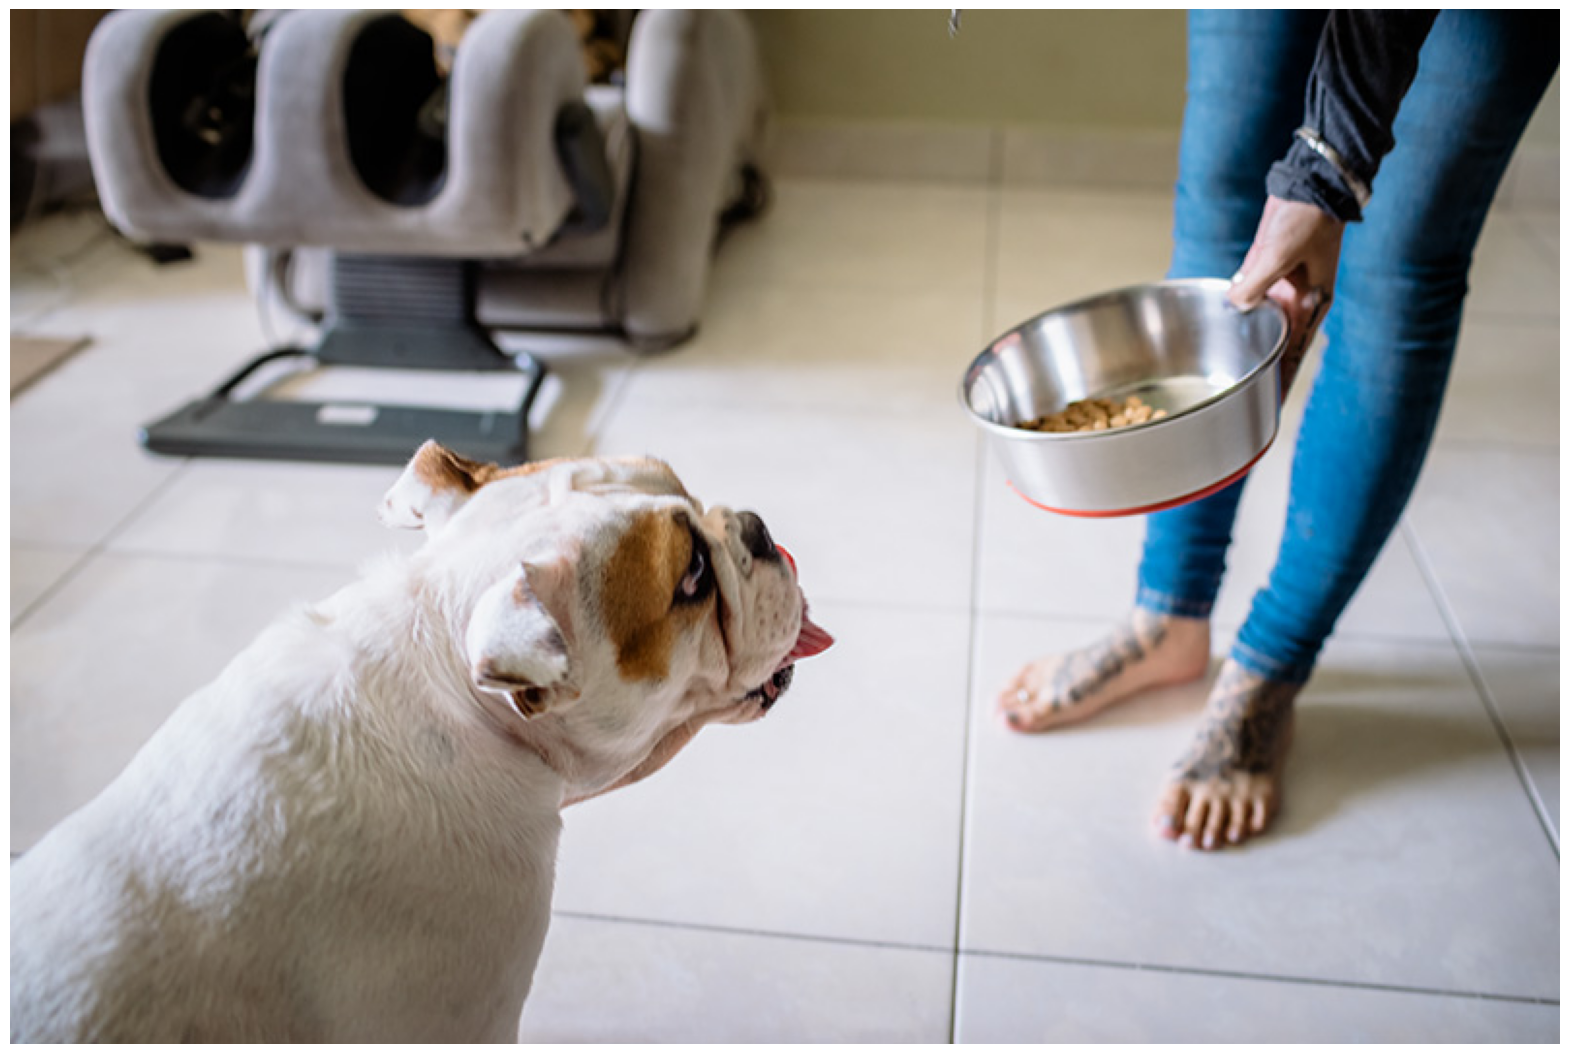

In [5]:
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')

plt.show()

## Automatic mask generation

To run automatic mask generation, provide a SAM model to the `SamAutomaticMaskGenerator` class. Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.

In [6]:
sam_checkpoint = "/Users/liudun/Desktop/anno_tools/AnnotationTools/sam_vit_h_4b8939.pth"
# device = "cuda"
# device = "mps"
device = "cpu"
model_type = "default"

In [7]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

To generate masks, just run `generate` on an image.

In [11]:
masks = mask_generator.generate(image)

TypeError: Cannot convert a MPS Tensor to float64 dtype as the MPS framework doesn't support float64. Please use float32 instead.

Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:
* `segmentation` : the mask
* `area` : the area of the mask in pixels
* `bbox` : the boundary box of the mask in XYWH format
* `predicted_iou` : the model's own prediction for the quality of the mask
* `point_coords` : the sampled input point that generated this mask
* `stability_score` : an additional measure of mask quality
* `crop_box` : the crop of the image used to generate this mask in XYWH format

In [9]:
print(len(masks))
print(masks[0].keys())
# print(masks[0])

66
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


Show all the masks overlayed on the image.

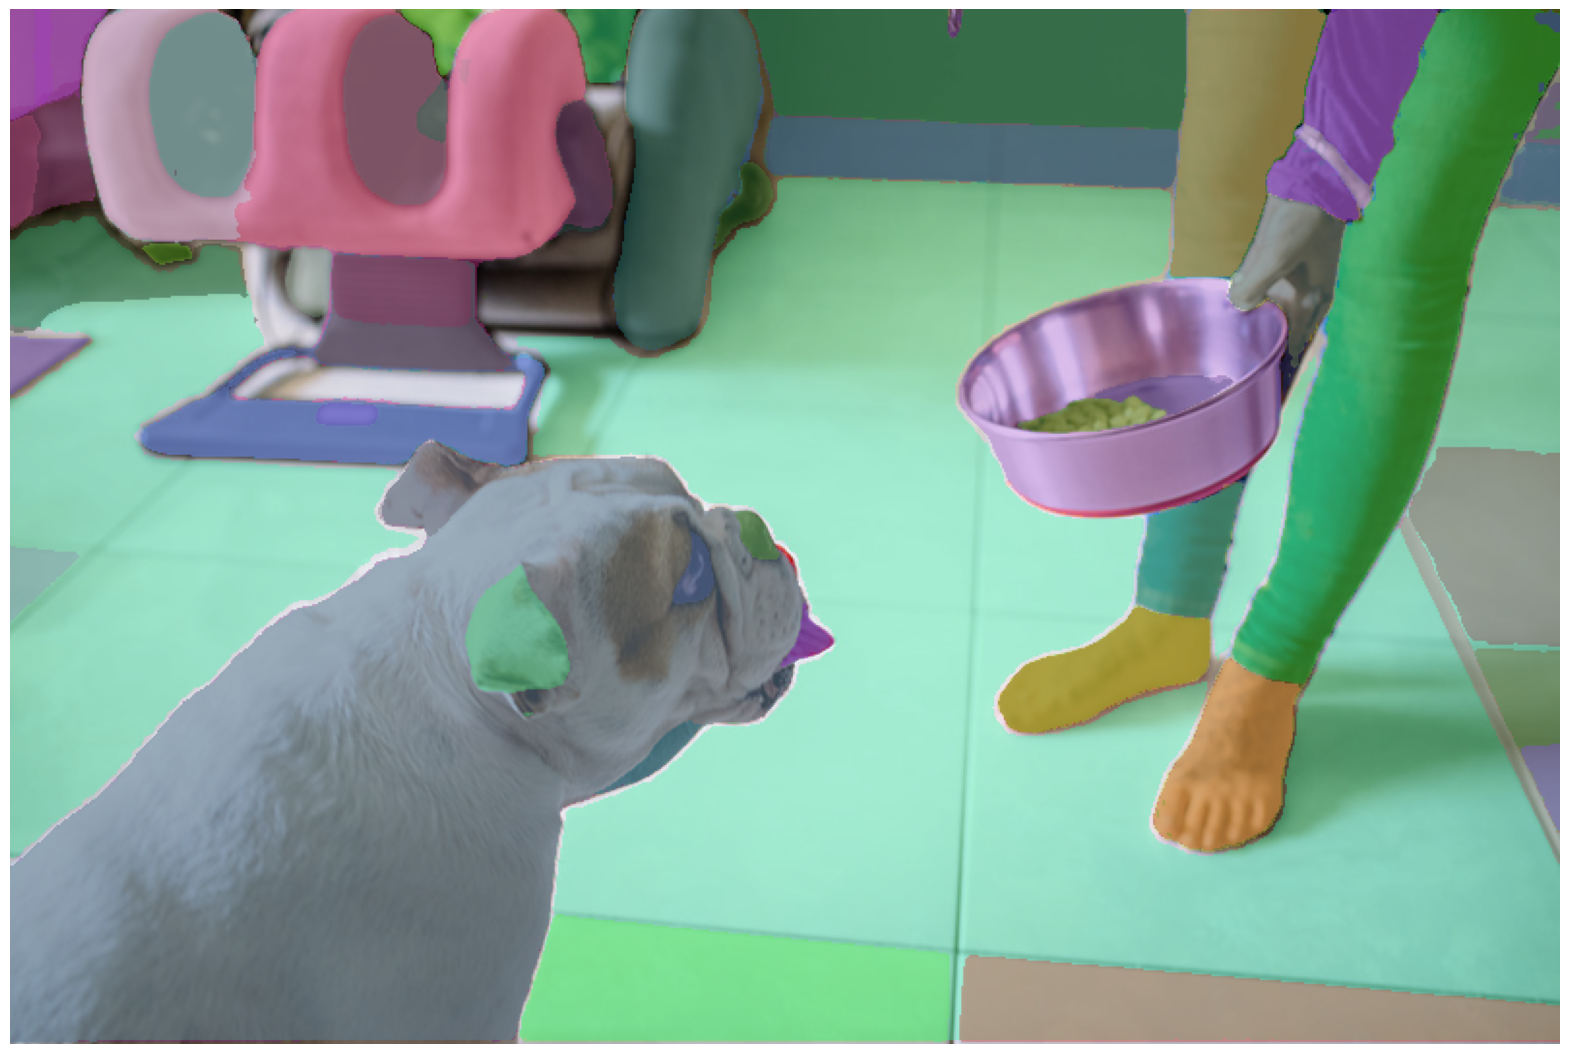

In [10]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

## Automatic mask generation options

There are several tunable parameters in automatic mask generation that control how densely points are sampled and what the thresholds are for removing low quality or duplicate masks. Additionally, generation can be automatically run on crops of the image to get improved performance on smaller objects, and post-processing can remove stray pixels and holes. Here is an example configuration that samples more masks:

In [13]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    # points_per_side=32,
    points_per_side=2,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

In [14]:
masks2 = mask_generator_2.generate(image)

In [15]:
len(masks2)

10

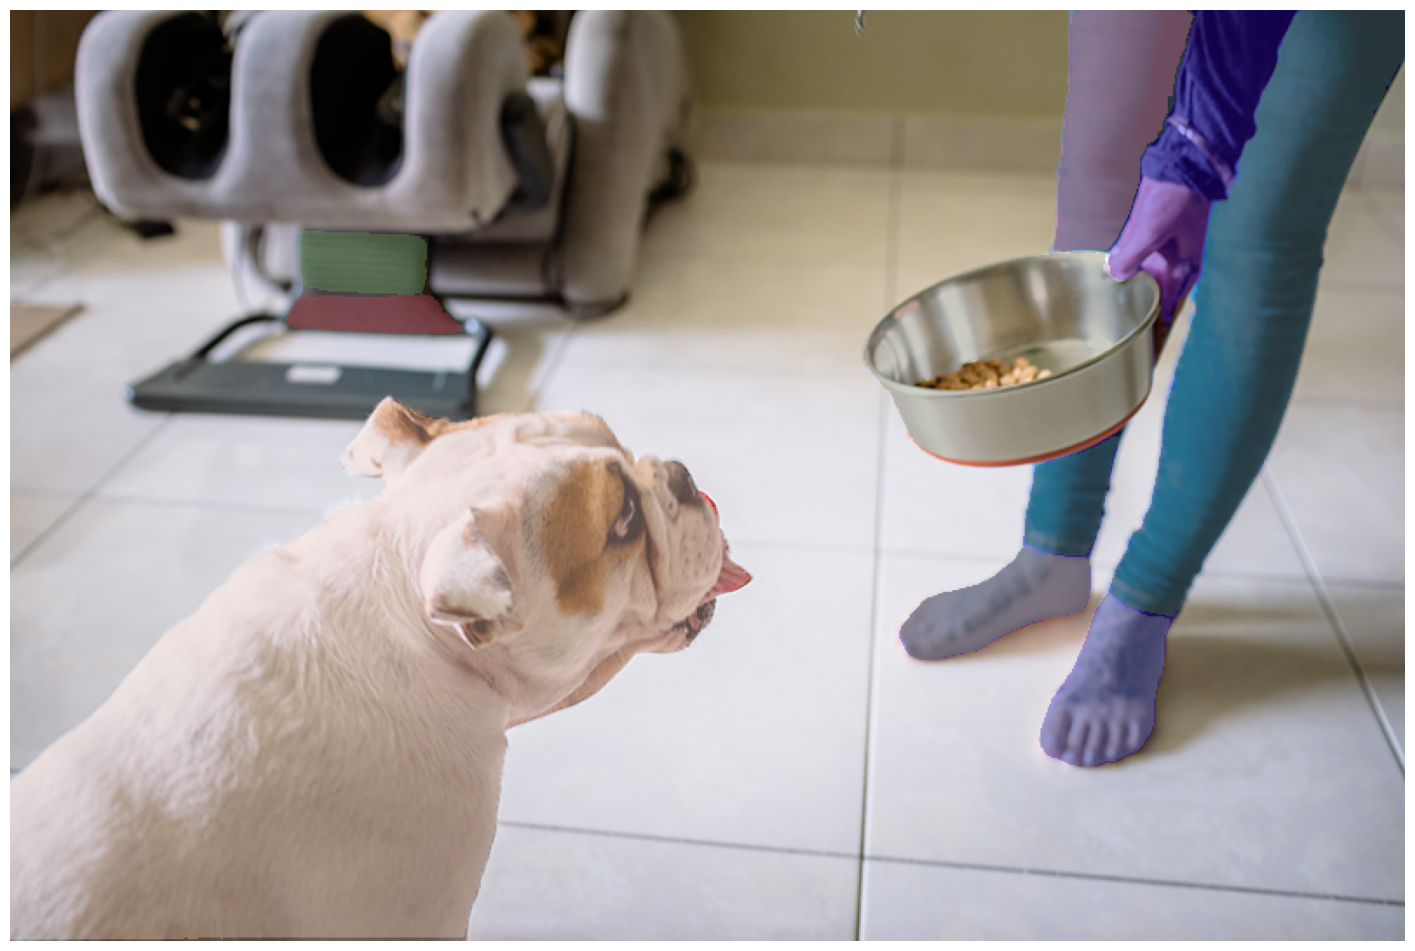

In [17]:
plt.figure(figsize=(18,18))
plt.imshow(image)
show_anns(masks2)
plt.axis('off')

myfig = plt.gcf()
myfig.savefig('/root/AnnotationTools/figure.png',dpi=300) #save myfig

plt.show() 

# 保存YTVIS19

In [18]:
# 可视化YTVIS数据集
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
import os
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt

def init_model(sam_checkpoint="/share/home/liudun/paperguides/segment-anything/sam_vit_h_4b8939.pth",model_type="default",device = "cuda"):
    sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
    sam.to(device=device)
    mask_generator = SamAutomaticMaskGenerator(sam)
    return mask_generator

def visible_ytvis(mask_generator,base_image_path="/share/home/liudun/paperguides/segment-anything/notebooks/images",base_image_name="dog.jpg",save_path="/share/home/liudun/paperguides/segment-anything/demo_imgs"):

    image = cv2.imread(os.path.join(base_image_path,base_image_name))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    masks = mask_generator.generate(image)

    plt.figure(figsize=(18,18))
    plt.imshow(image)
    show_anns(masks)
    plt.axis('off')

    myfig = plt.gcf()
    myfig.savefig(os.path.join(save_path,base_image_name),dpi=300) #save myfig
    plt.close()
    # plt.show() 
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    # polygons = []
    # color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.35)))


In [19]:
mask_generator=init_model()
ytvis_base_path = "/share/home/liudun/VNext-main/datasets/ytvis_2019/val/JPEGImages"
for indexx,itemm in enumerate(os.listdir(ytvis_base_path)):
    save_path_dir=os.path.join("/share/home/liudun/paperguides/segment-anything/demo_imgs",itemm)
    if not os.path.exists(save_path_dir):
        os.makedirs(save_path_dir)
    origin_path_dir = os.path.join(ytvis_base_path,itemm)   
    print(itemm) 
    for item in os.listdir(origin_path_dir):
        if os.path.exists(os.path.join(save_path_dir,item)):
            continue
        print(item)
        visible_ytvis(base_image_path=origin_path_dir,base_image_name=item,save_path=save_path_dir,mask_generator=mask_generator)




# patharr=os.listdir("/share/home/liudun/paperguides/segment-anything/notebooks/images")
# print(patharr)
# for item in patharr:
#     visible_ytvis(base_image_name=item,mask_generator=mask_generator)

FileNotFoundError: [Errno 2] No such file or directory: '/share/home/liudun/paperguides/segment-anything/sam_vit_h_4b8939.pth'

: 